In [ ]:
"""
Neural Style Transfer
 
1. Neural style transfer consists of applying the style of a reference image to a target image while conserving the content of the target
   image.  In this context, style essentially means textures, colors, and visual patterns in the image, at various spatial scales; and
   the content is the higher-level macrostructure of the image

2. The key notion behind implementing style transfer is the same idea that’s central to all deep-learning algorithms: you define a loss
   function to specify what you want to achieve, and you minimize this loss. You know what you want to achieve: conserving the content of
   the original image while adopting the style of the reference image. If we were able to mathematically define content and style,
   then an appropriate loss function to minimize would be the following:
   (*) loss = distance(style(reference_image) - style(generated_image)) +
              distance(content(original_image) - content(generated_image))

3. Here, distance is a norm function such as the L2 norm, content is a function that takes an image and computes a representation of
   its content, and style is a function that takes an image and computes a representation of its style. Minimizing this loss causes style
   (generated_image) to be close to style(reference_image), and content(generated_image) is close to content(generated_image), thus
   achieving style transfer.
"""

In [ ]:
"""
The Content Loss

1. The Activations from earlier layers in a network contain local information about the image, whereas activations from higher layers
   contain increasingly global, abstract information. Formulated in a different way, the activations of the different layers of a convnet
   provide a decomposition of the contents of an image over different spatial scales. Therefore, you’d expect the content of an image,
   which is more global and abstract, to be captured by the representations of the upper layers in a convnet.

2. A good candidate for content loss is thus the L2 norm between the activations of an upper layer in a pretrained convnet, computed over
   the target image, and the activations of the same layer computed over the generated image. This guarantees that, as seen from the upper
   layer, the generated image will look similar to the original target image. Assuming that what the upper layers of a convnet see is
   really the content of their input images, then this works as a way to preserve image content. 
"""

In [ ]:
"""
The Style Loss

1. The content loss only uses a single upper layer, but the style loss as defined by Gatys et al. uses multiple layers of a convnet:
   you try to capture the appearance of the stylereference image at all spatial scales extracted by the convnet, not just a single scale.

2. For the style loss, Gatys et al. use the Gram matrix of a layer’s activations: the inner product of the feature maps of a given layer.
   This inner product can be understood as representing a map of the correlations between the layer’s features. These feature correlations
   capture the statistics of the patterns of a particular spatial scale, which empirically correspond to the appearance of the textures
   found at this scale.

3. Hence, the style loss aims to preserve similar internal correlations within the activations of different layers, across
   the style-reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales look
   similar across the style-reference image and the generated image.
"""

In [ ]:
"""
In short, you can use a pretrained convnet to define a loss

-- Preserve content by maintaining similar high-level layer activations between the target content image and the generated image.
   The convnet should “see” both the target image and the generated image as containing the same things.

-- Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Feature
   correlations capture textures: the generated image and the style-reference image should share the same textures at different spatial
   scales.
"""

In [3]:
"""
Neural style transfer in Keras

This is the general process:
-- Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image
   at the same time.
-- Use the layer activations computed over these three images to define the loss function described earlier, which you’ll minimize in
   order to achieve style transfer.
-- Set up a gradient-descent process to minimize this loss function.
"""
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# path to the image
target_image_path = './data/style/portrait.png'
style_reference_image_path = './data/style/popova.png'

# Dimensions of the generated picture
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)
print(width, height)
print(img_width, img_height)

251 252
398 400


In [4]:
"""
Auxiliary functions for loading, preprocessing, and postprocessing the images that go in and out of the VGG19 convnet
"""
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
"""
Set up the VGG19 network

It takes as input a batch of three images: the stylereference image, the target image, and a placeholder that will contain the generated
image. A placeholder is a symbolic tensor, the values of which are provided externally via Numpy arrays. The style-reference and target
image are static and thus defined using K.constant, whereas the values contained in the placeholder of the generated image will change
over time.
"""
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')
print(model.summary())

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (3, 400, 398, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 398, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 398, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 199, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 199, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 199, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 99, 128)         0      

In [7]:
"""
Loss (1)
"""

# Content Loss: make sure the top layer of the VGG19 convnet has a similar view of the target image and the generated imag
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# Style Loss: use an auxiliary function to compute the Gram matrix of an input matrix: a map of the correlations found
#             in the original feature matrix.
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Total variation loss: operates on the pixels of the generated combination image. It encourages spatial continuity in
#                       the generated image, thus avoiding overly pixelated results. You can interpret it as a regularization loss.
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [10]:
"""
Loss (2)

1. The loss that you minimize is a weighted average of these three losses. To compute the content loss, you use only one upper layer —
   the block5_conv2 layer — whereas for the style loss, you use a list of layers than spans both low-level and high-level layers. You
   add the total variation loss at the end.

2. Depending on the style-reference image and content image you’re using, you’ll likely want to tune the content_weight coefficient
   (the contribution of the content loss to the total loss). A higher content_weight means the target content will be more recognizable
   in the generated image.
"""


# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Name of layer used for content loss
content_layer = 'block5_conv2'

# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [11]:
"""
Gradient-descent Process (1)


1. Set up the gradient descent process: In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm,
   so that is also what we will use here. This is a key difference from the Deep Dream example. The L-BFGS algorithms comes packaged
   with SciPy. However, there are two slight limitations with the SciPy implementation:
   -- It requires to be passed the value of the loss function and the value of the gradients as two separate functions.
   -- It can only be applied to flat vectors, whereas we have a 3D image array.

2. It would be very inefficient for us to compute the value of the loss function and the value of gradients independently, since it would
   lead to a lot of redundant computation between the two. We would be almost twice slower than we could be by computing them jointly. 
   To by-pass this, we set up a Python class named Evaluator that will compute both loss value and gradients value at once, will return 
   the loss value when called the first time, and will cache the gradients for the next call.
"""


# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [12]:
"""
Gradient-descent Process (2)
"""

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 9347804000.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 8s
Start of iteration 1


/data/home/zhangmu/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 3441750500.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 2270590000.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 5s
Start of iteration 3
Current loss value: 1716250200.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 5s
Start of iteration 4
Current loss value: 1433782800.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 5s
Start of iteration 5
Current loss value: 1208983400.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 5s
Start of iteration 6
Current loss value: 1079531500.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 5s
Start of iteration 7
Current loss value: 952534660.0
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 5s
Start of iteration 8
Current loss value: 856828400.0
Ima

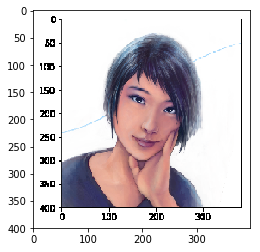

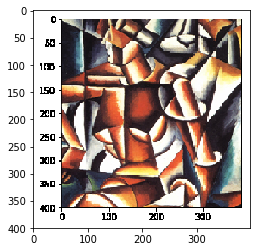

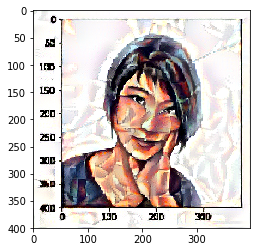

In [14]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()